<a href="https://colab.research.google.com/github/wczubal1/BloombergTask/blob/main/BloombergTaskWitoldCzubala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from statistics import NormalDist

In [ ]:
#!pip install scikit-learn
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from numpy import linalg
from scipy.stats import multivariate_normal
from statistics import NormalDist
from scipy.stats import norm

In [ ]:
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
import shap

In [ ]:
#Uploading corporate PD datset
#This was dowloaded from a provider I have an acess to. It is used to simulate default. The additional variables such as sector or financial metrics will be factors in the estimated model
data_root = "https://raw.githubusercontent.com/wczubal1/BloombergTask/main/"
df_credit = pd.read_csv(data_root + "df_credit.csv")

In [ ]:
df_credit

,Instrument,CompanyName,BusinessSector,CompanyMarketCap,CreditCombinedPD,ReturnOnAssets,TotalDebttoCommonEquity,PriceMomentumT12MVolatility
0,TXG.OQ,10X Genomics Inc,Healthcare Services & Equipment,5.554622e+09,0.083735,-16.21,NaN,14.111801
1,FCNCA.OQ,First Citizens BancShares Inc (Delaware),Banking & Investment Services,2.005774e+10,0.251288,1.01,0.92905,24.651832
2,ME.OQ,23andMe Holding Co.,Healthcare Services & Equipment,3.392539e+08,0.235883,-29.76,NaN,14.719923
3,TSVT.OQ,2Seventy Bio Inc,Pharmaceuticals & Medical Research,1.893360e+08,0.414782,NaN,NaN,34.163690
4,DDD.N,3D Systems Corp,Technology Equipment,6.925227e+08,0.459605,-1.96,0.60469,21.900110
...,...,...,...,...,...,...,...,...
2324,ZI.OQ,Zoominfo Technologies Inc,Software & IT Services,6.127379e+09,0.216172,5.20,0.54393,18.089863
2325,ZS.OQ,Zscaler Inc,Software & IT Services,3.423091e+10,0.049608,8.65,1.56412,16.097909
2326,ZUMZ.OQ,Zumiez Inc,Retailers,3.589960e+08,0.233710,2.61,0.00000,13.146578
2327,ZUO.N,Zuora Inc,Software & IT Services,1.209195e+09,0.081718,NaN,2.16553,16.002749


In [ ]:
#Count number of rows with missing values
print (df_credit.isna().any(axis=1).sum())

802


In [ ]:
#Removing missing values and resetting the index
df_credit=df_credit.dropna()
df_credit= df_credit.reset_index(drop=True)

In [ ]:
#Summary of PDs in the dataset
df_credit['CreditCombinedPD'].describe()

count    1527.000000
mean        0.283032
std         0.493445
min         0.006694
25%         0.074972
50%         0.140495
75%         0.269909
max         5.972882
Name: CreditCombinedPD, dtype: float64

In [ ]:
#Generating random numbers from uniform distribution for default simulation
np.random.seed(12345);
df_credit.loc[:,'randNumCol'] = np.random.uniform(0, 1, df_credit.shape[0])

In [ ]:
#simulating default
#scaling parameter
k=5
df_credit.loc[:,'Default'] = df_credit['randNumCol']<(k*df_credit['CreditCombinedPD']/100)

In [ ]:
print('Number of defaults: ', sum(df_credit['Default']))
df_credit.loc[df_credit['Default']==True,['Default','BusinessSector']].groupby('BusinessSector').sum()

Number of defaults:  27


,Default
BusinessSector,
Applied Resources,1
Banking & Investment Services,4
Cyclical Consumer Products,2
Cyclical Consumer Services,2
Food & Beverages,2
Healthcare Services & Equipment,1
Industrial Goods,2
Real Estate,4
Renewable Energy,1


In [ ]:
#Sector variables (to see how many companies in the sectors v defaults)
df_credit.groupby('BusinessSector').size()

BusinessSector
Applied Resources                                   17
Automobiles & Auto Parts                            23
Banking & Investment Services                      199
Chemicals                                           32
Consumer Goods Conglomerates                         6
Cyclical Consumer Products                          64
Cyclical Consumer Services                          78
Energy - Fossil Fuels                               67
Financial Technology (Fintech) & Infrastructure      8
Food & Beverages                                    44
Food & Drug Retailing                               12
Healthcare Services & Equipment                    109
Industrial & Commercial Services                    68
Industrial Goods                                   100
Insurance                                           40
Mineral Resources                                   19
Personal & Household Products & Services            19
Pharmaceuticals & Medical Research                

In [ ]:
###### This part estimates logistic regression

In [ ]:
#Creating dummies for selected sector
dummies=pd.get_dummies(df_credit['BusinessSector'])
#keeping these sectors: Finance due to contagion, Real Estate due to rates sensitivity and Healthcare and Utilities as not sensitive to economic cycle. Allowing too many sectors might problematic given low number of defaults
dummies=dummies[['Banking & Investment Services','Healthcare Services & Equipment','Real Estate','Utilities']]
df_credit=pd.concat([df_credit, dummies],axis=1)

In [ ]:
#Estimation dataset (dropping several columns)
df_estimation= df_credit[df_credit.columns.difference(['Instrument', 'CompanyName', 'BusinessSector', 'CompanyMarketCap', 'CreditCombinedPD', 'randNumCol'])]

In [ ]:
#Remaining variables for the estiation
df_estimation.columns

Index(['Banking & Investment Services', 'Default',
       'Healthcare Services & Equipment', 'PriceMomentumT12MVolatility',
       'Real Estate', 'ReturnOnAssets', 'TotalDebttoCommonEquity',
       'Utilities'],
      dtype='object')

In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_estimation.drop(['Default'],axis=1), df_estimation['Default'], test_size=0.25)

# Create the logistic regression model
#model = LogisticRegression()
#Adding regularization penalty and inverse of regularization strength. Also class weight as the dataset is not balanced.
#These hyperparameters can be further optimized/tuned using GridSearchCV or similar package though it is computationally very consuming and can lead to overfitted model
model = LogisticRegression(penalty='l1', C=12, solver='liblinear',max_iter=1000,class_weight={0: 0.08, 1: 0.92})

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = model.score(X_test, y_test)
print('Accuracy:', accuracy)
accuracy = model.score(X_train, y_train)
print('Accuracy:', accuracy)

Accuracy: 0.9764397905759162
Accuracy: 0.9755458515283842


In [ ]:
#Model coefficients
pd.DataFrame([df_estimation.drop(['Default'],axis=1).columns,np.transpose(model.coef_)]).T.sort_values(1)

,0,1
1,Healthcare Services & Equipment,[-0.20609965367075372]
5,TotalDebttoCommonEquity,[-0.007484619195448311]
4,ReturnOnAssets,[0.001598403621164644]
2,PriceMomentumT12MVolatility,[0.060745969438535746]
0,Banking & Investment Services,[0.13086849706915402]
6,Utilities,[0.9641240761933115]
3,Real Estate,[1.2399353172459]


In [ ]:
#Confusion matrix for test and train data
confusion_matrix(y_test, model.predict(X_test))
#confusion_matrix(y_train, model.predict(X_train))

array([[373,   3],
       [  6,   0]])

In [ ]:
#Classification report for the results
print(classification_report(y_test, model.predict(X_test)))
#print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99       376
        True       0.00      0.00      0.00         6

    accuracy                           0.98       382
   macro avg       0.49      0.50      0.49       382
weighted avg       0.97      0.98      0.97       382



In [ ]:
############## This section estimates XGboost model on the same data
#The hyperparameters below can be further optimized/tuned using GridSearchCV or similar package though it is computationally very consuming and can lead to overfitted model
final_model = XGBClassifier(objective = "binary:logistic",
                         n_estimators = 99,
                         gamma = 0,
                         importance_type='gain',
                         eval_metric = "mlogloss",
                         max_depth = 3,
                         learning_rate = 0.05,
                         max_delta_step=0,
                         booster="gbtree",
                         min_child_weight = 1,
                         scale_pos_weight = None,
                         verbosity = 1)
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=99,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

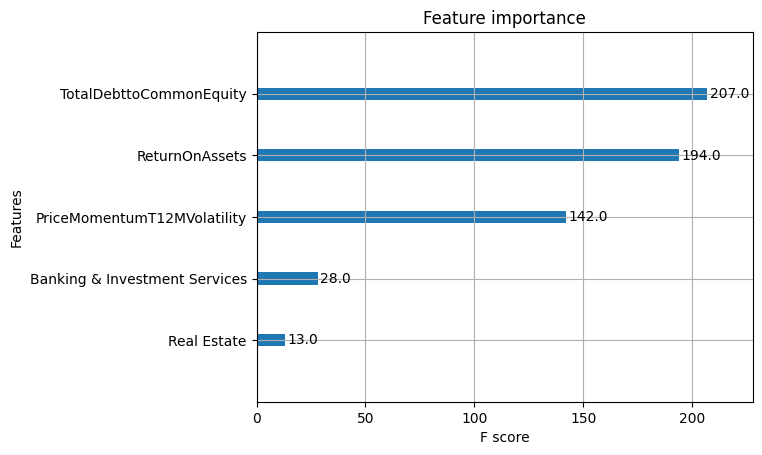

In [ ]:
#Ploting most important features from XGboost model
from xgboost import plot_importance
import matplotlib.pylab as plt
from matplotlib import pyplot
plot_importance(final_model, max_num_features=10)
plt.show()
plt.close()

In [ ]:
confusion_matrix(y_test, final_model.predict(X_test))
#confusion_matrix(y_train, final_model.predict(X_train))

array([[376,   0],
       [  6,   0]])

In [ ]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99       376
        True       0.00      0.00      0.00         6

    accuracy                           0.98       382
   macro avg       0.49      0.50      0.49       382
weighted avg       0.97      0.98      0.97       382



In [ ]:
# plotting mariginal impact of variables with Shapley values
explainer = shap.TreeExplainer(final_model, data=X_train, model_output="probability")
shap_values = explainer.shap_values(X_train)
print(shap_values.shape)

[01:24:36] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


(1145, 7)


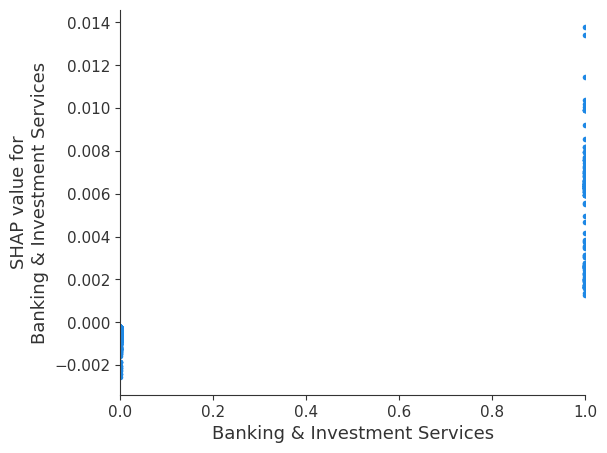

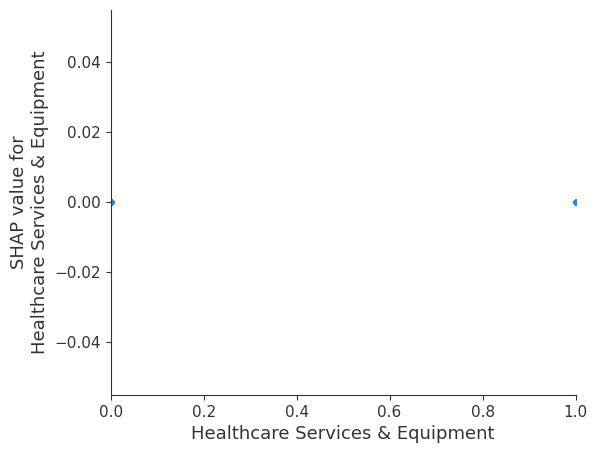

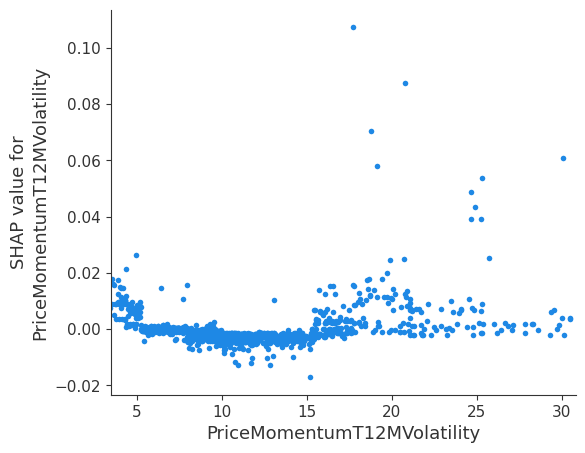

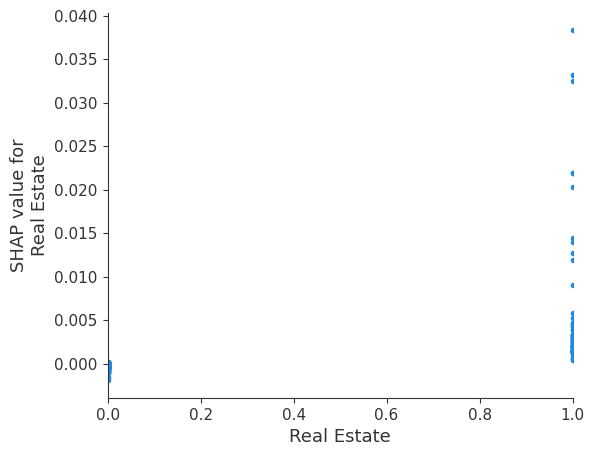

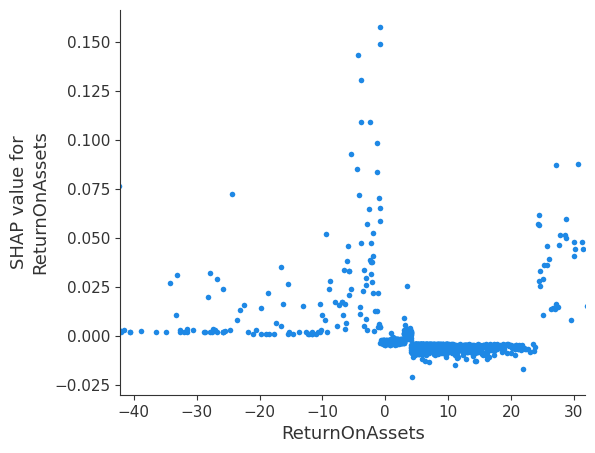

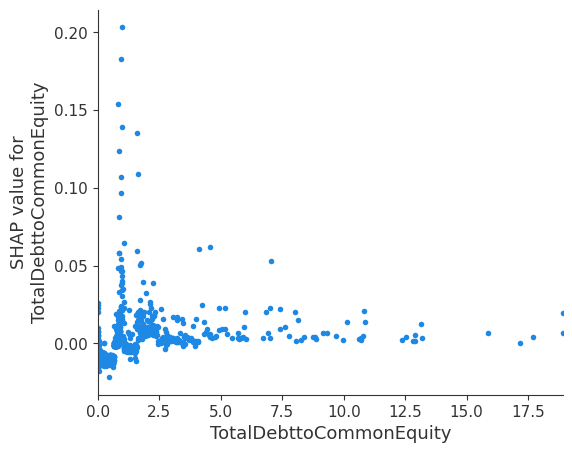

In [ ]:
# plotting mariginal impact of variables with Shapley values
for i in range(0,X_train.shape[1]-1):
    shap.dependence_plot(X_train.columns[i], shap_values, X_train, interaction_index=None, show=False)
    plt.xlim(X_train[X_train.columns[i]].quantile(0.01),X_train[X_train.columns[i]].quantile(0.99))
    plt.show()

In [ ]:
############ This section explores adding correlation to the defaults by using Gaussian copula
#Create correlation matrix
#Assumption is that companies in the Banking & Investment Services have correlated defaults due to contagion
corr_matrix=np.identity(df_credit.shape[0])

In [ ]:
#correlation value when business sector is Banking
BankingRows=df_credit[df_credit['BusinessSector']=='Banking & Investment Services'].index

for r in BankingRows:
    for c in BankingRows:
        corr_matrix[r, c]=0.95


In [ ]:
#Adding 1s to diagonal
np.fill_diagonal(corr_matrix, 1)

In [ ]:
#Generating correlated random normal through Cholesky decomposition
L=linalg.cholesky(corr_matrix)
# Create a multivariate normal distribution object with 100 simulations
np.random.seed(12);
mvn = np.random.multivariate_normal(np.zeros((df_credit.shape[0])),np.identity(df_credit.shape[0]),size=100)
#Multiplying by matrix from Cholesky decomposition to get correltions
mvn_corr=L.dot(mvn.T)

In [ ]:
#Checking index for companies from Banking & Investment Services
df_credit[df_credit['BusinessSector']=='Banking & Investment Services'].index

Int64Index([   0,    5,   33,   67,   85,   90,   91,  126,  132,  140,
            ...
            1472, 1474, 1478, 1480, 1482, 1496, 1501, 1503, 1509, 1521],
           dtype='int64', length=199)

In [ ]:
#The obs from the index below are from banking, their correlations should be around 0.95. Selecting a few of them confirms that correlation matrix is constructed correctly
#   0,    5,   33,   67,   85,   90,   91,  126,  132,  140,
#            ...
#            1472, 1474, 1478, 1480, 1482, 1496, 1501, 1503, 1509, 1521],
print(np.corrcoef(mvn_corr[90,:],mvn_corr[1521,:]))

[[1.         0.94581433]
 [0.94581433 1.        ]]


In [ ]:
#getting probabilities using normal cdf
df_corr=pd.DataFrame(norm.cdf(mvn_corr))
df_corr

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.681888,0.964570,0.472600,0.365640,0.005149,0.340756,0.843642,0.477695,0.677612,0.391889,...,0.397835,0.589206,0.894847,0.939284,0.964381,0.701299,0.192242,0.473447,0.100275,0.081046
1,0.247801,0.780628,0.574148,0.620812,0.296850,0.811728,0.876142,0.691463,0.779633,0.597466,...,0.944666,0.983057,0.452963,0.598670,0.006147,0.743631,0.123412,0.057248,0.713260,0.206591
2,0.595780,0.202891,0.748026,0.099368,0.148472,0.609526,0.998331,0.840631,0.301766,0.849417,...,0.765602,0.728274,0.238906,0.764122,0.048640,0.701369,0.901834,0.565513,0.718878,0.623656
3,0.044496,0.996286,0.583009,0.591587,0.785790,0.073334,0.027287,0.310282,0.749684,0.888729,...,0.883215,0.568551,0.450450,0.901335,0.649960,0.956712,0.539490,0.474091,0.839863,0.995692
4,0.774318,0.209373,0.623424,0.646964,0.394275,0.114959,0.772099,0.656084,0.288121,0.103099,...,0.740803,0.994976,0.771189,0.015835,0.067659,0.587306,0.701984,0.239612,0.552932,0.902937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522,0.224738,0.170473,0.220350,0.124376,0.531250,0.660312,0.662342,0.867965,0.200412,0.947506,...,0.314429,0.977609,0.273462,0.208791,0.055434,0.800072,0.155146,0.633504,0.820458,0.633634
1523,0.802137,0.633089,0.599487,0.577741,0.895686,0.084208,0.691111,0.694082,0.295624,0.065832,...,0.160193,0.783061,0.994108,0.025740,0.862915,0.495462,0.000274,0.841365,0.069800,0.841863
1524,0.409634,0.966679,0.948222,0.976985,0.533104,0.814646,0.909028,0.639398,0.140519,0.362924,...,0.427878,0.102788,0.819848,0.718245,0.199246,0.054756,0.572420,0.761403,0.620643,0.617037
1525,0.201848,0.648165,0.758305,0.163210,0.729251,0.607986,0.995674,0.497447,0.702166,0.186254,...,0.518739,0.741274,0.879421,0.008454,0.307564,0.431994,0.542647,0.687716,0.888211,0.540219


In [ ]:
#Simulating defaults with 0.95 correlation for banking
df_corr =df_corr < k*df_credit[['CreditCombinedPD']].values/100

In [ ]:
#Adding business sector to defaults results
df_corr.loc[:,'BusinessSector'] = df_credit['BusinessSector']

In [ ]:
#summarizing defaults by sector for 100 simulations. We can see that Banking has a tendency to either have 0 defaults or very high defaults
df_corr.groupby('BusinessSector').sum()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
BusinessSector,,,,,,,,,,,,,,,,,,,,,
Applied Resources,0,1,0,0,0,1,1,0,1,0,...,1,0,1,0,0,0,0,0,0,0
Automobiles & Auto Parts,0,0,1,0,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,1
Banking & Investment Services,0,0,0,0,178,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
Chemicals,0,1,1,0,2,1,0,3,1,1,...,0,0,2,1,0,1,0,0,1,1
Consumer Goods Conglomerates,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cyclical Consumer Products,2,1,1,0,1,1,1,0,1,2,...,1,0,1,1,0,0,1,1,0,0
Cyclical Consumer Services,3,1,1,2,0,0,0,1,2,0,...,2,1,4,2,1,2,0,3,1,3
Energy - Fossil Fuels,0,0,1,2,2,1,0,2,0,1,...,0,0,0,1,1,2,0,1,1,0
Financial Technology (Fintech) & Infrastructure,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
